# 练习1

Q: 构建计算图而不是直接运行计算的主要优点是什么？缺点呢？

A: 优点：1. 可以利用其它高效计算接口运算；2. 可以在GPU上运行；3. 可以很方便的并发。缺点：1. 不能直接获得返回结果，debug困难。

# 练习2

Q: a_val = a.eval(session=sess) 和 a_val = sess.run(a) 相同吗？

A: 相同的。

# 练习3

Q: a_val, b_val = a.eval(session=sess), b.eval(session=sess) 和 a_val, b_val = sess.run([a, b]) 相同吗？

A: 不同。前者计算多次已经计算的结果，不会共享值。后者计算会共享值。

# 练习4

Q: 可以在相同的sess下运行两个计算图吗？

A: 可以。使用 `tf.Graph()` 创建新的图谱。

# 练习5

Q: 如果你构建了一个包含变量 w 的图 g，然后启动两个线程，每个线程中打开一个session，他们都使用相同的图 g，每个session会有他们独立的变量 w 的备份，还是他们会共享变量 w？

A: 独立的。只有分布式存储在服务器上的变量状态才会共享。

# 练习6

Q: 变量什么时候初始化？什么时候销毁？

A: 在运行sess.run(init)的时候初始化，在关闭sess的时候销毁。

# 练习7

Q: placeholder 和 variable的区别？

A: placeholder只输出传递给他的值。variable是变量，可以更新值。

# 练习8

Q: 你运行了一个基于placeholder的图，但是没有给feed_dict会发生什么？如果不基于placeholder呢？

A: 会出错，因为没有给placeholder传值。那就不会报错。

# 练习9

Q: 运行图形时，是否可以提供任何操作的输出值，或仅提供占位符的值？

A: 都是可以的。

# 练习10

Q: 如何将变量设置为您想要的任何值（在执行阶段）？

A: 使用 `tf.assign()` 进行赋值。

# 练习11

Q: How many times does reverse-mode autodiff need to traverse the graph in order to compute the gradients of the cost function with regards to 10 variables? What about forward-mode autodiff? And symbolic differentiation?

A: 2，10，N/A

# 练习12

Q: 使用TensorFlow实现基于小批量梯度下降的逻辑回归。使用moons数据集。
    - Define the graph within a logistic_regression() function that can be reused easily
    - Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.
    - Restore the last checkpoint upon startup if training was interrupted.
    - Define the graph using nice scopes so the graph looks good in TensorBoard.
    - Add summaries to visualize the learning curves in TensorBoard.
    - Try tweaking some hyperparameters such as the learning rate or the mini- batch size and look at the shape of the learning curve.

首先导入一些必要的包

In [402]:
from datetime import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf

%matplotlib inline

In [80]:
def plot_decision_bundary(estimator, X, y, title=None, num=100):
    """"""
    X1_lin = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, num=num)
    X2_lin = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, num=num)
    X11, X22 = np.meshgrid(X1_lin, X2_lin)
    Z = estimator.predict(np.c_[X11.ravel(), X22.ravel()]).reshape(X11.shape)
    plt.contourf(X1_lin, X2_lin, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    if title:
        plt.title(title)

In [424]:
class LogisticRegressionCV(object):
    def __init__(self, input_dim, output_dim, poly_degree=None, penalty='elastic-net', penalty_r=0.5, alpha=1.0, 
                 learning_rate=0.01, batch_size=64, epochs=10, save_interval=5, epsilon=1e-7, logdir='/tmp'):
        self.timestamp_ = datetime.now().strftime("%Y%m%d%H%M%S")
        self._fitted = False
        tf.reset_default_graph()
        self.poly_degree = poly_degree
        self.penalty = penalty
        self.penalty_r = penalty_r
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.save_interval = save_interval
        self.epsilon = epsilon
        self.logdir = self.get_logdir(logdir)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        with tf.name_scope("model"):
            self.X = tf.placeholder(tf.float32, shape=(None, input_dim + 1), name="X")
            self.y = tf.placeholder(tf.float32, shape=(None, output_dim), name="y")
            self.theta = tf.Variable(tf.random_uniform((input_dim + 1, 1), -1.0, 1.0, seed=42), dtype=tf.float32, name="theta")
            self.y_pred = tf.sigmoid(tf.matmul(self.X, self.theta, name="z"), name="sigmoid")
        self.best_theta_ = None
        self.model_path_ = None
        self.epoch_path_ = None
    
    def load_epoch(self):
        """加载epoch"""
        if self.epoch_path_ is None:
            return 0
        with open(self.epoch_path_, 'rb') as f:
            epoch = f.read().strip()
        return int(epoch)
    
    def dump_epoch(self, epoch):
        """存储epoch"""
        self.epoch_path_ = '/tmp/epoch-%s' % self.timestamp_
        with open(self.epoch_path_, 'wb') as f:
            f.write(b"%d" % epoch)
    
    def poly_input(self, X):
        """对数据集使用次方
        只会使用数据集的n次方，而不会进行组合
        """
        X_org = np.array(X)
        for degree in range(2, self.poly_degree + 1):
            X = np.c_[X, X_org ** degree]
        return X
    
    def add_bias(self, X):
        """添加偏置项"""
        return np.c_[np.ones((X.shape[0], 1)), X].astype(np.float32)
    
    def get_logdir(self, base_logdir):
        """获得TensorBoard日志目录"""
        return os.path.join(base_logdir, 'run-%s' % self.timestamp_)
        
    def get_batch_data(self, X, y, batch_size):
        """获取小批量数据集"""
        idx = np.random.randint(0, X.shape[0], size=batch_size)
        X_batch = X[idx]
        y_batch = y[idx]
        return X_batch, y_batch
    
    def penalty_part(self, alpha, penalty, penalty_r=0):
        """正则项
        一个问题：目前正则化了theta_0
        """
        if penalty == 'l1':
            return alpha * tf.reduce_mean(tf.norm(self.theta, ord=1), name="penalty")
        if penalty == 'l2':
            return alpha * tf.reduce_mean(tf.norm(self.theta, ord=2), name="penalty")
        if penalty == 'elastic-net':
            l1 = alpha * tf.reduce_mean(tf.norm(self.theta, ord=1), name="l1")
            l2 = alpha * tf.reduce_mean(tf.norm(self.theta, ord=2), name="l2")
            return l1 * penalty_r + (1 - penalty_r) * l2
        raise ValueError("penalty must be 'l1', 'l2' or 'elastic-net'")
    
    def fit(self, X, y=None):
        """训练模型"""
        if self.poly_degree:
            X = self.poly_input(X)
        X = self.add_bias(X)
        start_epoch = self.load_epoch()
        with tf.name_scope("train"):
#             error = self.y_pred - self.y
#             mse = tf.reduce_mean(tf.square(error), name="mse")
#             cross_entropy = -tf.reduce_mean(self.y * tf.log(self.y_pred + self.epsilon) + (1 - self.y) * tf.log(1 - self.y_pred + self.epsilon), name="cross_entropy")
            cross_entropy = tf.losses.log_loss(self.y, self.y_pred)
            if self.penalty:
                cross_entropy += self.penalty_part(self.alpha, self.penalty, self.penalty_r)

            optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
            train_op = optimizer.minimize(cross_entropy, name="train")
        
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        n_batches = int(np.ceil(X.shape[0] * 1. / self.batch_size))
        if self.logdir:
            error_summary = tf.summary.scalar("CROSS_ENTROPY", cross_entropy)
            log_writer = tf.summary.FileWriter(self.logdir, tf.get_default_graph())
        with tf.Session() as sess:
            sess.run(init)
            for epoch in range(start_epoch, self.epochs + 1):
                for batch_index in range(n_batches):
                    X_batch, y_batch = self.get_batch_data(X, y, self.batch_size)
                    sess.run(train_op, feed_dict={self.X: X_batch, self.y: y_batch})
                if epoch % self.save_interval == 0:
                    self.dump_epoch(epoch)
                    self.saver.save(sess, '/tmp/logistic_regression_last.ckpt')
                    if self.logdir:
                        summary_str = error_summary.eval(feed_dict={self.X: X_batch, self.y: y_batch})
                        step = epoch * n_batches + batch_index
                        log_writer.add_summary(summary_str, step)
            self.best_theta_ = self.theta.eval()
            self.model_path_ = '/tmp/logistic_regression_final.ckpt'
            self.saver.save(sess, self.model_path_)
            log_writer.close()
        self._fitted = True
        return self
    
    def predict(self, X):
        """预测"""
        if not self._fitted:
            raise RuntimeError("you must run `fit` first.")
        X = np.array(X)
        X = self.poly_input(X)
        X_plus_bias = self.add_bias(X)
        with tf.Session() as sess:
            self.saver.restore(sess, self.model_path_)
            y_pred = sess.run(self.y_pred, feed_dict={self.X: X_plus_bias})
        return (y_pred >= 0.5) * 1

获取数据，并划分为训练集、验证集和测试集

In [425]:
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train, _X, y_train, _y = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(_X, _y, test_size=0.5, random_state=42)
print("train X shape:", X_train.shape)
print("train y shape:", y_train.shape)
print("validate X shape:", X_val.shape)
print("validate y shape:", y_val.shape)
print("test X shape:", X_test.shape)
print("test y shape:", y_test.shape)

train X shape: (800, 2)
train y shape: (800,)
validate X shape: (100, 2)
validate y shape: (100,)
test X shape: (100, 2)
test y shape: (100,)


定义模型并运行

In [419]:
logistic_regression_cv = LogisticRegressionCV(X_train.shape[1] * 3, y_train.reshape(-1, 1).shape[1], poly_degree=3, 
                                              penalty=None, penalty_r=0.9, alpha=0.01, learning_rate=0.01, epochs=10000)
logistic_regression_cv.fit(X, y.reshape(-1, 1))
print(logistic_regression_cv.logdir)

/tmp/run-20180915163644


做出决策边界

INFO:tensorflow:Restoring parameters from /tmp/logistic_regression_final.ckpt


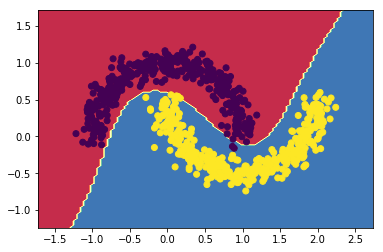

In [422]:
plot_decision_bundary(logistic_regression_cv, X_train, y_train)

In [423]:
print("train score:", accuracy_score(y_train, logistic_regression_cv.predict(X_train)))
print("validate score:", accuracy_score(y_val, logistic_regression_cv.predict(X_val)))

INFO:tensorflow:Restoring parameters from /tmp/logistic_regression_final.ckpt
train score: 0.9925
INFO:tensorflow:Restoring parameters from /tmp/logistic_regression_final.ckpt
validate score: 0.99


使用SVM进行对比

In [414]:
from sklearn.svm import SVC

In [415]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

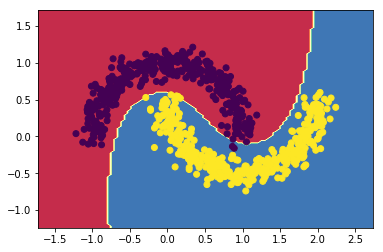

In [416]:
plot_decision_bundary(svc, X_train, y_train)

In [434]:
print("train score:", accuracy_score(y_train, svc.predict(X_train)))
print("validate score:", accuracy_score(y_val, svc.predict(X_val)))

train score: 0.99375
validate score: 0.99


分数差不多，但是决策边界看起来会好很多